In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

income = pd.read_csv("../Data/income.csv")

income.head()

,age,JobType,EdType,maritalstatus,occupation,relationship,race,gender,capitalgain,capitalloss,hoursperweek,nativecountry,SalStat
0,45,Private,HS-grad,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,28,United-States,"less than or equal to 50,000"
1,24,Federal-gov,HS-grad,Never-married,Armed-Forces,Own-child,White,Male,0,0,40,United-States,"less than or equal to 50,000"
2,44,Private,Some-college,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,"greater than 50,000"
3,27,Private,9th,Never-married,Craft-repair,Other-relative,White,Male,0,0,40,Mexico,"less than or equal to 50,000"
4,20,Private,Some-college,Never-married,Sales,Not-in-family,White,Male,0,0,35,United-States,"less than or equal to 50,000"


In [2]:
def income_model_prep(data):
    from sklearn.model_selection import train_test_split
    data = pd.get_dummies(
        data.assign(
            target = np.where(data["SalStat"] == " less than or equal to 50,000", 0, 1),
            nativecountry = data["nativecountry"].replace({" Holand-Netherlands": " Germany"}),
            occupation = data["occupation"].replace({" Armed-Forces": " ?"}),
            JobType = data["JobType"].replace({" Never-worked": " Without-pay"}),
        ).drop("SalStat", axis=1), 
        drop_first=True
    )
    X = data.drop("target", axis=1)
    y = data["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = income_model_prep(income) 

# Assignment 1: Simple Tree

1. Build a decision tree with max_depth 3 using the `age`, `hoursperweek` and `gender` features.
2. Calculate accuracy and build a confusion matrix for the test data
3. Plot the tree - which group has the highest probability of making over 50,000?
4. Plot Feature importance - which variable was most important? Are there any we can drop?

In [4]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=3)
dt = dt.fit(X_train, y_train)

print(f"Train Score: {dt.score(X_train, y_train)}")
print(f"Test Score: {dt.score(X_test, y_test)}")

Train Score: 0.8194042686263779
Test Score: 0.8258286429018137


Accuracy: 0.8258286429018137
Precision: 0.9387308533916849
Recall: 0.28316831683168314
F1: 0.43509127789046653


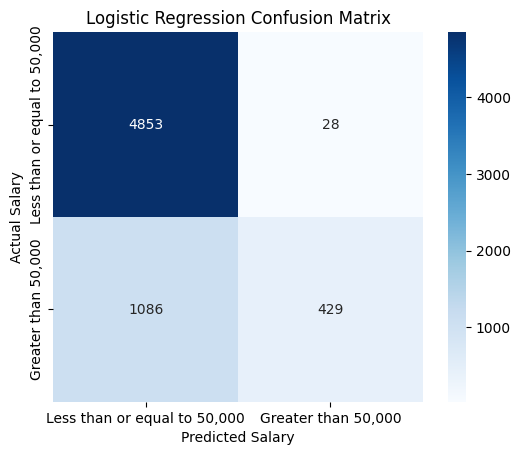

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print(f"Accuracy: {accuracy_score(y_test, dt.predict(X_test))}")
print(f"Precision: {precision_score(y_test, dt.predict(X_test))}")
print(f"Recall: {recall_score(y_test, dt.predict(X_test))}")
print(f"F1: {f1_score(y_test, dt.predict(X_test))}")

dt_confusion = confusion_matrix(y_test, dt.predict(X_test))
                                 
sns.heatmap(
    dt_confusion, 
    cmap="Blues",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["Less than or equal to 50,000", "Greater than 50,000"],        
    yticklabels=["Less than or equal to 50,000", "Greater than 50,000"]
).set(
    xlabel='Predicted Salary',
    ylabel='Actual Salary',
    title='Logistic Regression Confusion Matrix'
);

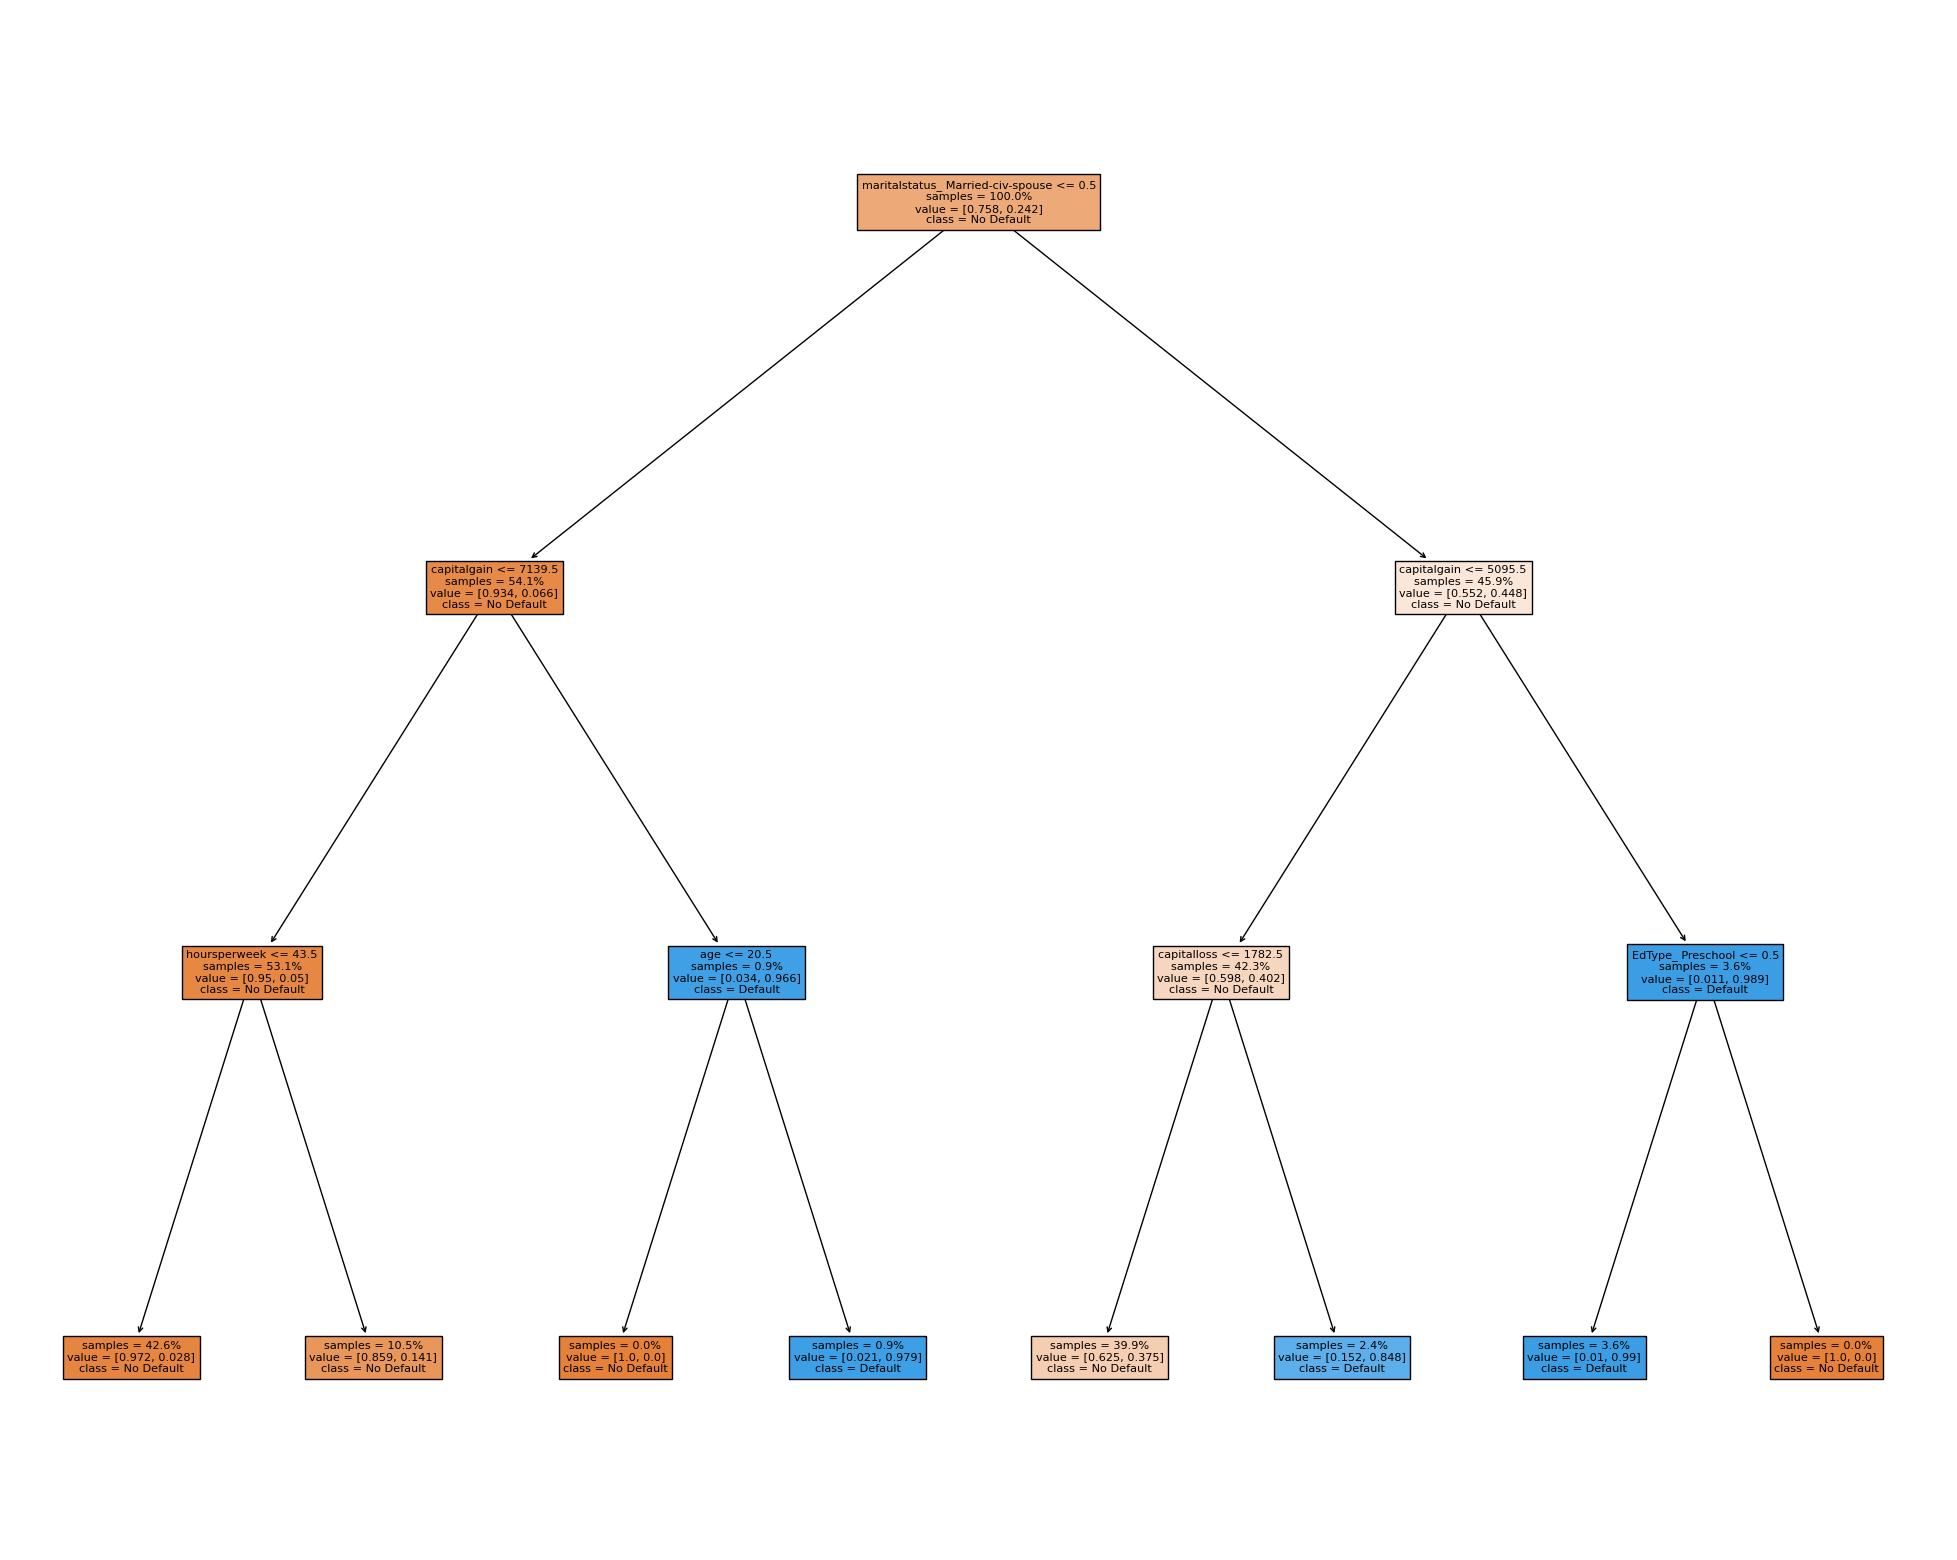

In [6]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25,20))

plot_tree(
    dt, 
    feature_names=list(X_train.columns),
    class_names=["No Default", "Default"],
    impurity=False,
    proportion=True,
    filled=True
);

In [11]:
sorted(dt.feature_importances_)[::-1][:6]

[0.5876885722502053,
 0.3105552506285465,
 0.08161202165621774,
 0.01773054015702865,
 0.0017941846659642235,
 0.000619430642037559]

In [12]:
importance_df = (
    pd.DataFrame({
        "feature": X_train.columns, 
        "importance": dt.feature_importances_
    })
    .sort_values("importance", ascending=False)
)

importance_df

,feature,importance
27,maritalstatus_ Married-civ-spouse,0.587689
1,capitalgain,0.310555
2,capitalloss,0.081612
3,hoursperweek,0.017731
0,age,0.001794
...,...,...
32,occupation_ Adm-clerical,0.000000
31,maritalstatus_ Widowed,0.000000
30,maritalstatus_ Separated,0.000000
29,maritalstatus_ Never-married,0.000000


<Axes: xlabel='importance', ylabel='feature'>

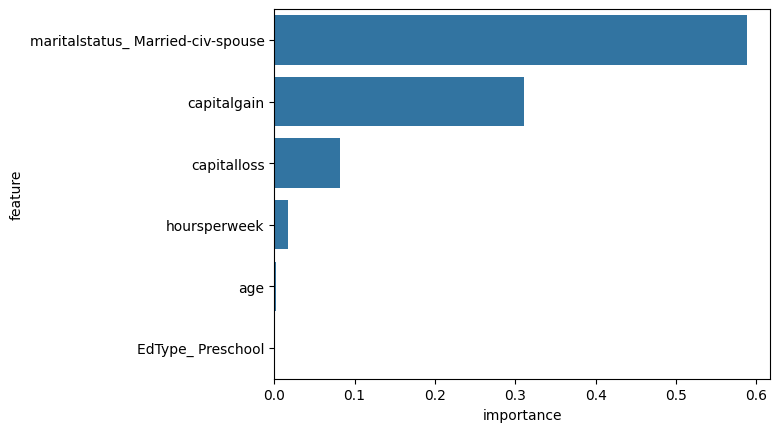

In [13]:
import seaborn as sns

sns.barplot(importance_df[:6], x="importance", y="feature")

# Assignment 2: Hyperparameter Tuning

1. Use cross validation to find the optimal tree parameters. Your process should evaluate different values of max_depth, 'min_samples_leaf', and 'criterion'. 
2. Generate a confusion matrix and report test accuracy, precision, and recall

In [24]:
from sklearn.model_selection import GridSearchCV

params = {
    "criterion": ["entropy", "gini", "log_loss"],
    "max_depth": [10, 11, 12, 13, 14],
    "min_samples_leaf": [24, 25, 26, 27]
}

grid = GridSearchCV(DecisionTreeClassifier(), params)

grid.fit(X_train, y_train)

grid.best_params_

{'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 25}

In [27]:
dt = DecisionTreeClassifier(**grid.best_params_)

dt.fit(X_train, y_train)

print(f"Train Accuracy: {round(dt.score(X_train, y_train), 3)}")
print(f"Test Accuracy: {round(dt.score(X_test, y_test), 3)}")

Train Accuracy: 0.862
Test Accuracy: 0.86


Accuracy: 0.8602251407129456
Precision: 0.7585345545378851
Recall: 0.6013201320132013
F1: 0.6708394698085419


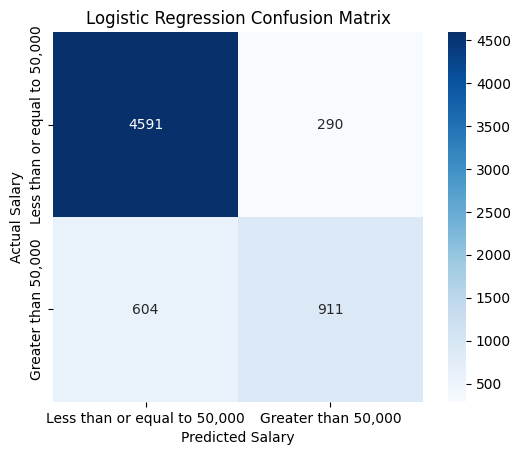

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print(f"Accuracy: {accuracy_score(y_test, dt.predict(X_test))}")
print(f"Precision: {precision_score(y_test, dt.predict(X_test))}")
print(f"Recall: {recall_score(y_test, dt.predict(X_test))}")
print(f"F1: {f1_score(y_test, dt.predict(X_test))}")

dt_confusion = confusion_matrix(y_test, dt.predict(X_test))
                                 
sns.heatmap(
    dt_confusion, 
    cmap="Blues",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["Less than or equal to 50,000", "Greater than 50,000"],        
    yticklabels=["Less than or equal to 50,000", "Greater than 50,000"]
).set(
    xlabel='Predicted Salary',
    ylabel='Actual Salary',
    title='Logistic Regression Confusion Matrix'
);